In [1]:
import torch
from torch import nn
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose, RandomPerspective, RandomRotation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
dev

'cuda'

In [2]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
    __str__ = __repr__

In [3]:
std_transform = Compose([
    ToTensor(),
    RandomPerspective(),
    AddGaussianNoise(0., 0.2),
    RandomRotation(10),
    Normalize((0.1307), (0.3081)),
])

In [4]:
train_ds = MNIST(root='downloads', train=True, download=True, transform = std_transform)
valid_ds = MNIST(root='downloads', train=False, download=True, transform = std_transform)

In [5]:
train_loader = DataLoader(train_ds, batch_size=512, shuffle = True, drop_last = True)
valid_loader = DataLoader(valid_ds, batch_size=512, shuffle = True, drop_last = True)

Truth: tensor(0)
tensor(-2.2187) tensor(4.1651)


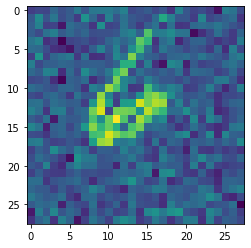

In [6]:
def print_imgs(model=None):
    if (model):
      plt.imshow(model(torch.randn(512, 128).to(dev).cpu().detach()[0,0], cmap='gray'))
    else:
      data, label = next(iter(train_loader))
      print("Truth:", label[0])
      plt.imshow(data[0,0], cmap='gray')
print_imgs()
data, label = next(iter(train_loader))
print(data[0].min(), data[0].max())
plt.imshow(data[0,0])
plt.show()

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1, 2, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(2, 4, 3, 1, 1),
        nn.ReLU(),
    )
    self.lin = nn.Sequential(
        nn.Flatten(),
        nn.Linear(4*28*28, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10),
        nn.Softmax(dim=1),
    )
    self.org = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 50),
        nn.ReLU(),
        nn.Linear(50, 50),
        nn.ReLU(),
        nn.Linear(50, 10),
        nn.Softmax(dim=1),
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.lin(x)
    return x

In [28]:
# model = Net().to(dev)
optim = torch.optim.Adam(model.parameters(), lr=1e-5)
cross_entropy = torch.nn.CrossEntropyLoss().to(dev)

In [29]:
def test(model, test_loader, cross_entropy):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(dev), target.to(dev)
            output = model(data)
            predict = cross_entropy(output.log(), target)
            test_loss += predict.item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    model.train()

In [30]:
epochs = 1000
# Lo entrene un ratito y tira a 87% con ruido con desviacion 0.4
for i in range(epochs):
    for batch_idx, (data, label) in enumerate(tqdm(train_loader, leave=False)):
        data, label = data.to(dev), label.to(dev)
        for p in model.parameters():
            p.grad = None

        predictions = model(data)
        loss = cross_entropy(predictions, label)

        loss.backward()
        optim.step()
    test(model, valid_loader, cross_entropy)

  0%|          | 0/117 [00:00<?, ?it/s]

Test set: Average loss: 0.0005, Accuracy: 9351/10000 (94%)


  0%|          | 0/117 [00:00<?, ?it/s]

Test set: Average loss: 0.0004, Accuracy: 9386/10000 (94%)


  0%|          | 0/117 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
test(model, valid_loader, cross_entropy)

Test set: Average loss: 0.0006, Accuracy: 9256/10000 (93%)
